In [1]:
##########==========##########==========##########==========##########==========

## HEAD

#### HEAD01 - load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches as mpatches

#### HEAD02 - load data files

In [3]:
def load_pickle(addr):
    conn = open(addr, 'rb')
    the_object = pickle.load(conn)
    conn.close()
    return the_object

handle_data = pd.read_excel('A_Input/twitter_handles.xlsx')
user_data = pd.read_csv('B_Process/user_data.csv')
tweet_data = pd.read_csv('B_Process/tweet_data.csv')
best_model_stats = load_pickle('B_Process/best_model_stats.pickle')


## load hparam files
logistic_hparams = load_pickle('B_Process/models/logistic_hparams.pickle')
bayes_hparams    = load_pickle('B_Process/models/bayes_hparams.pickle')
forest_hparams   = load_pickle('B_Process/models/forest_hparams.pickle')
adaboost_hparams = load_pickle('B_Process/models/adaboost_hparams.pickle')

/Users/s8/opt/anaconda3/envs/py310/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


#### HEAD03 - define plotting styles

In [4]:
## define a color palette
cp = {
    'AzureDark': '#021F33',
    'BrownDark': '#804419',
    'AzureFaded': '#466F91',
    'BrownFaded': '#916846',
    'AzureBg': '#CAD9E6',
    'BrownBg': '#E6D6CA',
    'AzureGrid': '#B4C1CC',
    'Trans': '#11223300'
    }
cp['AzureBgTrans'] = cp['AzureBg'] + '40'

## define font parameters
def define_pptx_font():
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Quicksand']
    plt.rcParams['font.weight'] = 'medium'
    plt.rcParams['font.size'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['axes.labelsize'] = 12
    

## define fonts
def define_pptx_style(color_palette = cp):
    
    plt.rcParams['figure.figsize'] = (4.5, 4.5)
    
    for i in plt.rcParams.keys():
        if i.endswith('color'): 
            try: plt.rcParams[i] = color_palette['AzureDark']
            except: print('cannot change: ', i)
        if i.endswith('facecolor'): 
            try: plt.rcParams[i] = color_palette['AzureBg']
            except: print('cannot change: ', i)
        if i.endswith('edgecolor'): 
            try: plt.rcParams[i] = color_palette['AzureDark']
            except: print('cannot change: ', i)


## PPTX

#### PPTX00 - define colors and fonts for plots

In [5]:
define_pptx_font()
define_pptx_style()

cannot change:  patch.force_edgecolor
cannot change:  patch.force_edgecolor
cannot change:  pdf.inheritcolor


#### PPTX 01 - Data Sources and Collection: Calculate data collection statistics

In [6]:
## calculate data collection statistics
def calculate_collection_stats(
    hd = handle_data, ud = user_data, td = tweet_data):
    
    ## define useful indices
    congress_idx = ['USA House', 'USA Senate']
    
    ## calculate handle_data statistics
    hd_stats = {
        'Total': hd.shape[0],
        'Congress': hd.group.value_counts().loc[congress_idx].sum(),
        'Republican': hd.party.value_counts().loc['Republican']
    }
    
    ## calculate user statistics
    include_idx = ud.ml_set != 'exclude'
    ud_stats = {
        'Total': ud.loc[include_idx].shape[0],
        'Congress': ud.group.loc[include_idx].value_counts().loc[
            congress_idx].sum(),
        'Republican': ud.party.loc[include_idx].value_counts().loc['Republican']
    }
    
    ##calcualte tweet statistics
    td_stats = {
        'Total': td.shape[0],
        'Congress': td.merge(ud, how = 'left', right_on = 'handle',
            left_on = 'screen_name').group.value_counts().loc[congress_idx].sum(),
        'Republican': td.merge(ud, how = 'left', right_on = 'handle',
            left_on = 'screen_name').party.value_counts().loc['Republican'].sum()
    }
    
    ## compile statistics
    col_stats = {'Handles': hd_stats, 'Users': ud_stats, 'Tweets': td_stats}
    
    return pd.DataFrame(col_stats).T


calculate_collection_stats()

,Total,Congress,Republican
Handles,796,537,263
Users,785,535,261
Tweets,100078,75039,37128


#### PPTX02 - Model Performance: Model performance scatterplot

In [7]:
## add plotting parameters to best_model_stats object
def add_plot_params_to_bms(bms = best_model_stats, col_pal = cp):
    
    ## prepare data
    bms[('time', 'run_time')] = (bms[('time', 'run_time')
        ]).fillna(min(bms[('time', 'run_time')].values))
    bms = bms.reset_index()
    
    ## parse names for useful data
    bms[('model', 'abbrev')] = bms[('model', 'algorithm')
                                  ].replace({'bayes':'NB', 'forest':'RF',
                                             'logistic':'LR', 'adaboost':'AB',
                                             'random':'RG'})
    bms[('model', 'stage')] = 'One-Stage'
    i = bms[('model', 'variant')].str.endswith('stage')
    bms.loc[i, ('model', 'stage')] = 'Two-Stage'
    bms[('model', 'x')] = 'Features'
    i = bms[('model', 'variant')].str.startswith('pca')
    bms.loc[i, ('model', 'x')] = 'PCA'
    
    ## set colors and style sizes
    bms[('plot', 'color')] = 'Azure'
    bms[('plot', 'shape')] = 's'
    bms[('plot', 'size')] = 140
    
    i = bms[('model', 'stage')] == 'One-Stage'
    bms.loc[i, ('plot', 'color')] = 'Brown'
    
    i = bms[('model', 'x')] == 'PCA'
    bms.loc[i, ('plot', 'color')] = bms.loc[i, ('plot', 'color')] + 'Faded'
    bms.loc[~i, ('plot', 'color')] = bms.loc[~i, ('plot', 'color')] + 'Dark'
    bms.loc[i, ('plot', 'shape')] = 'h'
    bms.loc[i, ('plot', 'size')] = 210
    
    for i in bms.index:
        bms.loc[i, ('plot', 'color')] = cp[bms.loc[i, ('plot', 'color')]]
    
    ## return data
    return bms

## execute code
best_model_stats = add_plot_params_to_bms()

In [8]:
def add_scatter_points(stage, x, bms = best_model_stats,
                       bgcol = cp['AzureBg'], zo = 10):
    i = bms[('model', 'stage')] == stage
    i = i & (bms[('model', 'x')] == x)
    
    ## render points
    plt.scatter(
        x = bms.loc[i, ('time', 'run_time')],
        y = bms.loc[i, ('perform', 'f1')],
        c = bms.loc[i, ('plot', 'color')].values[0],
        s = bms.loc[i, ('plot', 'size')],
        marker = bms.loc[i, ('plot', 'shape')].values[0],
        label = stage + ', ' + x,
        zorder = zo
        )
    
    ## render point labels
    for j in bms.index[i]:
        plt.text(
            x = bms.loc[j, ('time', 'run_time')],
            y = bms.loc[j, ('perform', 'f1')],
            s = bms.loc[j, ('model', 'abbrev')],
            c = bms.loc[j, ('plot', 'color')],
            fontsize = int(plt.rcParams['font.size'] * 0.5),
            ha = 'center', va = 'center', zorder = zo + 1,
            bbox = dict(facecolor = bgcol, edgecolor = '#00FF0000',
                       boxstyle = 'round')
        )

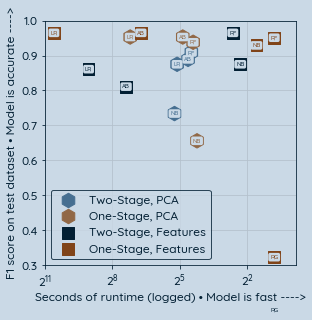

In [9]:
##  render points
add_scatter_points('Two-Stage', 'PCA', zo = 10)
add_scatter_points('One-Stage', 'PCA', zo = 12)
add_scatter_points('Two-Stage', 'Features', zo = 14)
add_scatter_points('One-Stage', 'Features', zo = 16)

## modify various plot aspects
plt.legend()
plt.gca().set_xlabel('Seconds of runtime (logged) • Model is fast ---->')
plt.gca().set_ylabel('F1 score on test dataset • Model is accurate ---->')
plt.gca().set_xlim((0.9, 2**11))
plt.gca().set_ylim(0.3, 1)
plt.gca().set_xscale('log', base = 2)
plt.gca().invert_xaxis()
plt.grid(color = cp['AzureGrid'])

## save image to disk
plt.gcf().savefig('C_Output/pptx_model_performance.pdf')

#### PPTX11 - Hyperparameter Testing: performance variability boxplots

In [10]:
## extract scoring information from hyperparameter search objects
def extract_test_scores(hparams, pca = False):
    
    ## extract scores
    result = dict()
    for i in hparams.keys():
        if pca:
            if i[0:3] == "pca":
                result[i] = hparams[i].cv_results_["mean_test_score"]
        else:
            if i[0:3] != "pca":
                result[i] = hparams[i].cv_results_["mean_test_score"]
            
    ## package and return
    result = pd.DataFrame(result)
    return result.values.reshape(-1, 1)

def compile_test_scores(hparam_dict = {
        'LR': logistic_hparams,
        'NB': bayes_hparams,
        'RF': forest_hparams,
        'AB': adaboost_hparams,
        }, get_pca = False):
    result = dict()
    max_length = 0
    for i in hparam_dict.keys():
        result[i] = pd.DataFrame(
            extract_test_scores(hparam_dict[i], pca = get_pca))
        result[i] = result[i].squeeze().sample(n = int(1e5), replace = True,
                                     random_state = 4561)
        result[i] = result[i].reset_index(drop = True)
        
    result = pd.DataFrame(result)

    return result

## execute code
hparams = compile_test_scores(get_pca = False)
hparams_pca = compile_test_scores(get_pca = True)
hparams = pd.concat([hparams, hparams_pca], axis = 1)

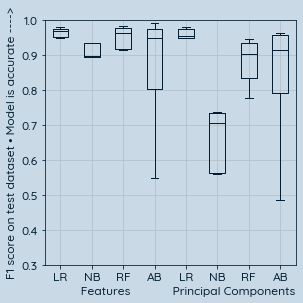

In [11]:
## generate boxplots to represent spread of accuracy scores given parameters
plt.boxplot(hparams, labels = hparams.columns, showfliers = False,
            whis = (10, 90))

## modify various plot aspects
plt.grid(color = cp['AzureGrid'])
plt.gca().set_ylim(0.3, 1)
plt.gca().set_ylabel('F1 score on test dataset • Model is accurate ---->')
plt.gca().set_xlabel(loc = 'left', xlabel = ' ' * 11 +'Features' +\
                     ' ' * 13 + 'Principal Components')

## save image
plt.gcf().savefig('C_Output/pptx_hyperparameter_performance.pdf')

## FOOT - display objects as needed